In [4]:
'''
This code was written by Lili Cai and Christopher Criscitiello
'''

'''
Load data
'''

import csv, numpy as np
from numpy import genfromtxt
import random

def openTxt(filename):
    file = open(filename,'r')
    newlist = file.read().split('\n')
    file.close()
    return newlist

# Open raw data files with positive and negative sentiments: 
test = openTxt('test.txt')
train = openTxt('train.txt')

# Open the list of words from 'test.txt' that appear a minimum of at least 5 times
# This list was created using preprocessSentences_v3_test.py, a script which was provided with the Assignment
vocabList = openTxt('train_vocab_5.txt')

# Open training and test data: 
# These bag of word files were created using preprocessSentences_v3_test.py 

# X_train is a 2d array where X_train[i] is x_i,from train_bag_of_words_5.csv
# y_train is a 1d array where y_train[i] is the label y_i
X_train = genfromtxt("train_bag_of_words_5.csv", delimiter=',')
y_train = genfromtxt("train_classes_5.txt", delimiter='\n')

# X_test is a 2d array where X_test[i] is x_i,from test_bag_of_words_5.csv
# y_test is a 1d array where y_test[i] is the label y_i
X_test = genfromtxt("test_bag_of_words_5.csv", delimiter=',')
y_test = genfromtxt("test_classes_5.txt", delimiter='\n')



In [5]:
'''
Explore Data
'''
# Helpfer function to display original example and its bag-of-words 
def exampleBowReps(num):    # Helper function to print BOW representation of from train sample
    print('Train #' + train[num])  # Can comment out this line to only display bag-of-words
    words_used = np.argwhere(X_train[num]==1)
    for w in words_used:
        print(vocabList[int(w)])
    print('-'*20)
        
# List 20 random examples and classify by hand
random.seed(5)
random_nums = [random.randint(1,2401) for i in range(20)]
random_nums.sort()

for ind, r in enumerate(random_nums):
    print('Example ' + str(ind+1))
    exampleBowReps(r)


Example 1
Train #    55	i got this phone around the end of may and i'm completely unhappy with it.	0
around
complet
end
got
may
phone
--------------------
Example 2
Train #   120	Worst Customer Service Ever.	0
custom
ever
servic
worst
--------------------
Example 3
Train #   214	I even fully charged it before I went to bed and turned off blue tooth and wi-fi and noticed that it only had 20 % left in the morning.	0
20
blue
charg
even
left
turn
went
--------------------
Example 4
Train #   419	It has a great camera thats 2MP, and the pics are nice and clear with great picture quality.	1
camera
clear
nice
pictur
qualiti
--------------------
Example 5
Train #   465	)Setup couldn't have been simpler.	1
--------------------
Example 6
Train #   644	We would recommend these to others.	1
other
recommend
would
--------------------
Example 7
Train #   889	NOBODY identifies with these characters because they're all cardboard cutouts and stereotypes (or predictably reverse-stereotypes).  	0
charact

In [6]:
'''
Create functions to run the classifiers and store results in 1 variable

'''
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from itertools import count
import seaborn as sn
import pandas as pd
from matplotlib.pyplot import figure


# Helper function to calculate and plot ROC and AUC
def calcRocAuc(predprob, label, figon='1'):  
    # False positive rate, true positive rate, threshold
    # fpr = 1-specificity = (# false positives) / (# total negatives)
    #       specificity = (# true negatives) / (# total negatives)
    # tpr = sensitivity = (# true positives) / (# total positives)
    fpr, tpr, thresholds = metrics.roc_curve(label, predprob, pos_label=0)
    auc = metrics.auc(fpr,tpr)   
    print('AUC: ' + str(auc) + '\n')
    if figon == 1:
        plt.plot(fpr,tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.show()
    return fpr, tpr, auc, thresholds

# Helpfer function to calculate and plot confusion matrix
def calcCFM(pred, label):
    cfm = confusion_matrix(pred, label).ravel()
    return cfm

# Helpfer function for cross validation
def calcCrossval(model):
    scores = cross_val_score(model, X_train, y_train, cv=10)
    print("Cross Val Training Accuracy: " + str(round(scores.mean(),3)) + ", STD: " + str(round(scores.std()*2,3)))
    return scores

# Create a class that contains a model and all its variables
# In this case, the 'class' is just a variable of a model
# that contains the model's relevant variables such as fpr, tpr, etc. 

# Helper function for confusion matrix
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plotCFM(cfm, name):
    nV = np.sum(cfm)   # normalization value
    array = [[cfm[3]/nV,cfm[1]/nV], 
             [cfm[2]/nV,cfm[0]/nV]]
    cm = pd.DataFrame(array, index = [i for i in ("Positive","Negative")],
                  columns = [i for i in ("Positive", "Negative")])
    plt.figure(figsize = (2,2))
    sn.heatmap(cm, annot=True, cmap="YlGnBu")
    plt.title(name + ' CFM: Test Data')
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.show()
    
class modDetails:    
    # This creates an umbrella variable that stores fpr, tpr, etc. for each 
    # classifier:
    #def __init__(self, fpr, tpr, 
    #             cfm_train, cfm_test,
    #             predictionsTrain, predictionsTest,
    #             tclassifier, train_cvscores, name, 
    #             predictionsTestProb=None,auc=None, thresholds=None):
    def __init__(self, fpr, tpr, cfm_train, cfm_test,
                            predictionsTrain, predictionsTest, 
                            classifier, train_cvscores, name, 
                            auc, thresholds, predictionsTestProb,
                               fpr_curve, tpr_curve):
        self.fpr = fpr
        self.tpr = tpr
        self.auc = auc
        self.fpr_curve = fpr_curve
        self.tpr_curve = tpr_curve
        self.thresholds = thresholds
        self.cfm_train = cfm_train
        self.cfm_test = cfm_test
        self.predictionsTrain = predictionsTrain
        self.predictionsTest = predictionsTest
        self.predictionsTestProb = predictionsTestProb
        self.classifier = classifier
        self.train_cvscores = train_cvscores
        self.name = name

print('done')        

C:\Users\lxc\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


done


In [7]:
def runModel2(model,name):
    print(name + '-'*50 + ' \n')
    
    # Train the Classifier
    # And obtain 10-fold cross validation results of the training
    if name.find('GMM') >= 0: # if this is GMM, only fit with X_train
        tt = model.fit(X_train)
    else:
        tt = model.fit(X_train,y_train)
    
    train_cvscores = calcCrossval(model)
    
    print(str(type(tt)))
    
    
    # Calculate classifier accuracy on trained data and test data
    predictionsTrain = tt.predict(X_train)
    predictionsTest = tt.predict(X_test)
    
    # Obtain confusion matrix for train and test data
    cfm_train = calcCFM(predictionsTrain, y_train)
    cfm_test= calcCFM(predictionsTest, y_test) 
    
    # fpr = 1-specificity = (# false positives) / (# total negatives)
    #       specificity = (# true negatives) / (# total negatives)
    # tpr = sensitivity = (# true positives) / (# total positives)
    # confusion matrix: tn, fp, fn, tp    
    tn = cfm_test[0]
    fp = cfm_test[1]
    fn = cfm_test[2]
    tp = cfm_test[3]
        
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    plotCFM(cfm_test, name)   
    
    # Calculate ROC and AUC. 
    # First, obtain probability distribution of the classifier:
    predictionsTestProb = tt.predict_proba(X_test)
    fpr_curve, tpr_curve, auc, thresholds = calcRocAuc(predictionsTestProb[:,0], y_test, 1)
    
    # Save results in one umbrella variable of the class modDetails
    #model_info = modDetails(fpr, tpr, 
    #                        cfm_train, cfm_test,
    #                        predictionsTrain, predictionsTest,
    #                        tt, train_cvscores, name, 
    #                        predictionsTestProb, auc, thresholds)    
    model_info = modDetails(fpr, tpr, cfm_train, cfm_test,
                            predictionsTrain, predictionsTest, 
                            tt, train_cvscores, name, 
                            auc, thresholds, predictionsTestProb,
                               fpr_curve, tpr_curve)
    return model_info

print('done')
'''
Check code: 
gnb = GaussianNB()
ttt = runModel2(gnb,'ttt')

classifier = gnb.fit(X_train,y_train)

gnb = GaussianNB()
trained_classifier = gnb.fit(X_train, y_train)

print(type(test))
print(type(trained_classifier))
print(type(classifier))
print(type(ttt))
'''

done


"\nCheck code: \ngnb = GaussianNB()\nttt = runModel2(gnb,'ttt')\n\nclassifier = gnb.fit(X_train,y_train)\n\ngnb = GaussianNB()\ntrained_classifier = gnb.fit(X_train, y_train)\n\nprint(type(test))\nprint(type(trained_classifier))\nprint(type(classifier))\nprint(type(ttt))\n"

In [8]:
from sklearn.feature_selection import RFE
# Helper function for recursive feature elimination (RFE)
def fs(model):
    selector = RFE(model, 10, step=1)
    selector.fit(X_train, y_train)
    print('10 most significant words, with corresponding coefficients')
    index = 0
    for i in range(len(selector.support_)):
        if selector.support_[i]:
            print(vocabList[i], selector.estimator_.coef_[0][index])
            index = index + 1

LogReg-L2-------------------------------------------------- 

Cross Val Training Accuracy: 0.779, STD: 0.046
<class 'sklearn.linear_model.logistic.LogisticRegression'>


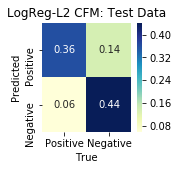

AUC: 0.877861111111111



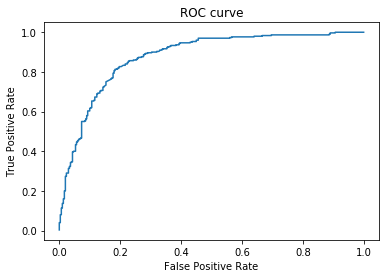

LogReg-L1-------------------------------------------------- 

Cross Val Training Accuracy: 0.782, STD: 0.055
<class 'sklearn.linear_model.logistic.LogisticRegression'>


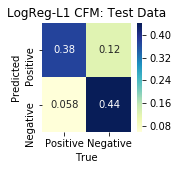

AUC: 0.8921



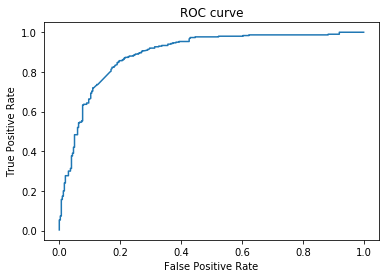

lda-------------------------------------------------- 

Cross Val Training Accuracy: 0.752, STD: 0.068
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>


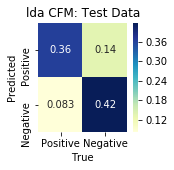

AUC: 0.8513611111111111



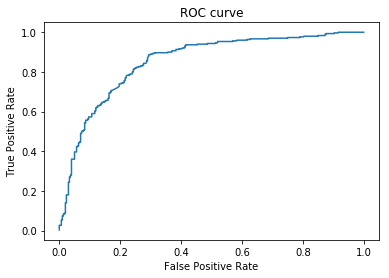

linear SVC-------------------------------------------------- 

Cross Val Training Accuracy: 0.778, STD: 0.06
<class 'sklearn.svm.classes.SVC'>


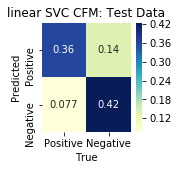

AUC: 0.861661111111111



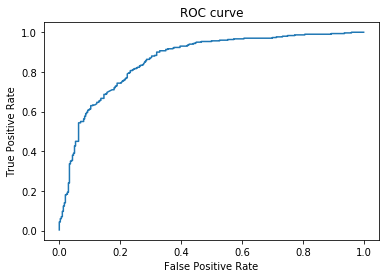

SVC rbf-------------------------------------------------- 

Cross Val Training Accuracy: 0.594, STD: 0.089
<class 'sklearn.svm.classes.SVC'>


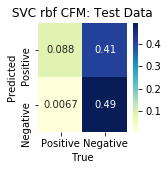

AUC: 0.8190277777777778



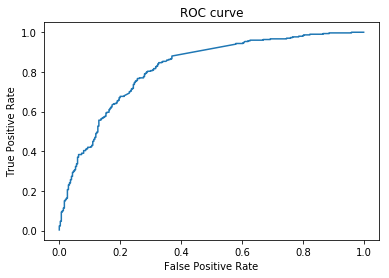

SVC linear, C100-------------------------------------------------- 

Cross Val Training Accuracy: 0.727, STD: 0.078
<class 'sklearn.svm.classes.SVC'>


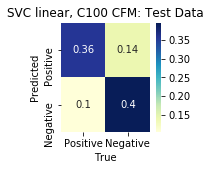

AUC: 0.8320388888888889



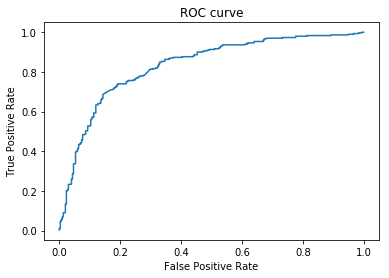

SVC linear, C1-------------------------------------------------- 

Cross Val Training Accuracy: 0.778, STD: 0.06
<class 'sklearn.svm.classes.SVC'>


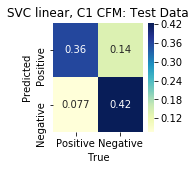

AUC: 0.8616722222222222



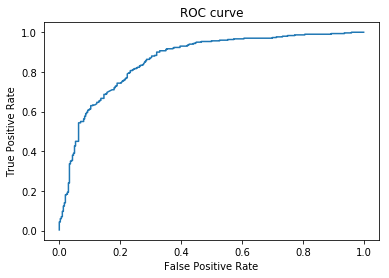

SVCnu-------------------------------------------------- 

Cross Val Training Accuracy: 0.775, STD: 0.056
<class 'sklearn.svm.classes.NuSVC'>


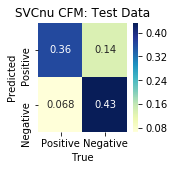

AUC: 0.8700166666666667



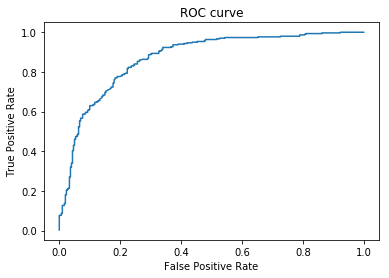

k3NN-------------------------------------------------- 

Cross Val Training Accuracy: 0.678, STD: 0.095
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>


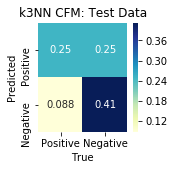

AUC: 0.7374944444444445



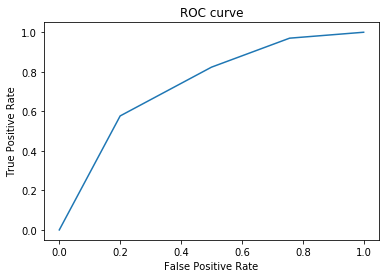

AdaBoost-------------------------------------------------- 

Cross Val Training Accuracy: 0.7, STD: 0.097
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>


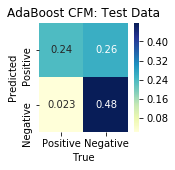

AUC: 0.7785277777777777



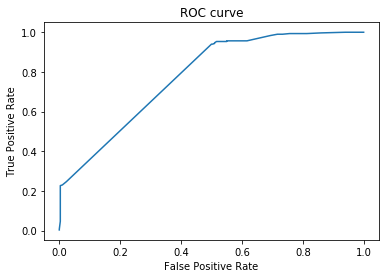

Gradient Boost-------------------------------------------------- 

Cross Val Training Accuracy: 0.743, STD: 0.085
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


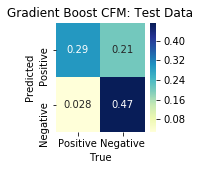

AUC: 0.8468222222222224



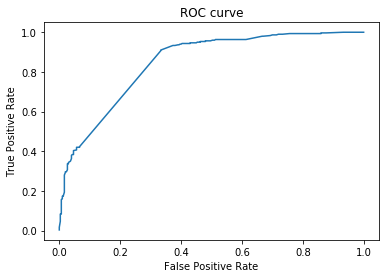

Random Forest-------------------------------------------------- 

Cross Val Training Accuracy: 0.705, STD: 0.081
<class 'sklearn.ensemble.forest.RandomForestClassifier'>


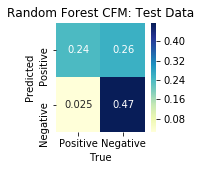

AUC: 0.8290777777777777



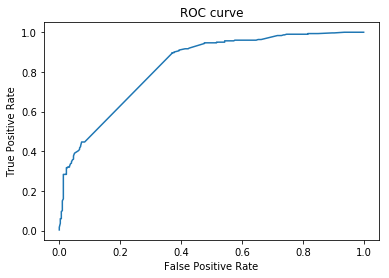

Decision Tree-------------------------------------------------- 

Cross Val Training Accuracy: 0.69, STD: 0.08
<class 'sklearn.tree.tree.DecisionTreeClassifier'>


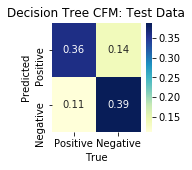

AUC: 0.7865722222222222



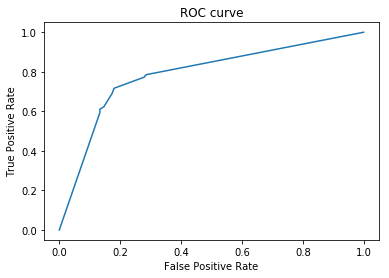

SVC linear, C100-------------------------------------------------- 

Cross Val Training Accuracy: 0.727, STD: 0.078
<class 'sklearn.svm.classes.SVC'>


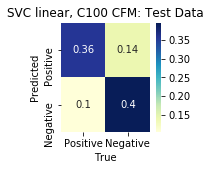

AUC: 0.8320611111111111



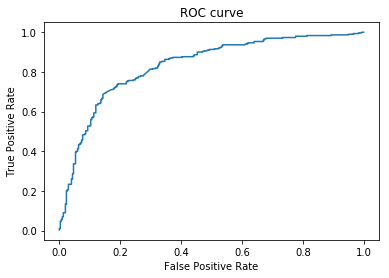

GaussianNB-------------------------------------------------- 

Cross Val Training Accuracy: 0.703, STD: 0.043
<class 'sklearn.naive_bayes.GaussianNB'>


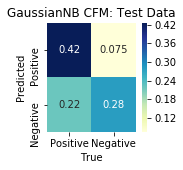

AUC: 0.8049166666666667



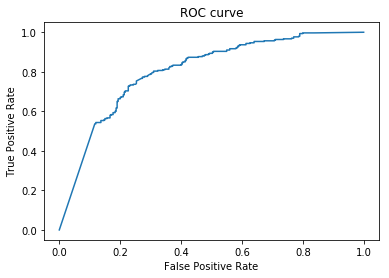

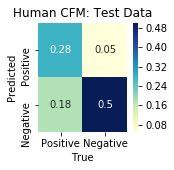

In [9]:
'''
Run Classifiers

fs() is a function that outputs the feature space. 
Uncomment those lines to run the code - they generally take a long time to run.

'''

# logistic regression with L2 regularization
logreg1 = LogisticRegression(C=1, penalty='l2', tol=0.01, solver='saga')
logregL2_info = runModel2(logreg1, 'LogReg-L2')
#fs(logreg1)

# train logistic regression with L1 regularization
logreg2 = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga')
logregL1_info = runModel2(logreg2, 'LogReg-L1')
#fs(logreg2)

# train LDA
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda_info = runModel2(lda, 'lda')
#fs(lda)

# train SVC
svc1 = svm.SVC(kernel = 'linear', probability=True)
svc1_info = runModel2(svc1, 'linear SVC')
#fs(svc1)

# train radial basis SVC
svc3 = svm.SVC(kernel = 'rbf', probability=True)
svc3_info = runModel2(svc3, 'SVC rbf')
#fs(svc3)


# train SVC
svc1 = svm.SVC(kernel = 'linear', C=100, probability=True)
svc1_info = runModel2(svc1, 'SVC linear, C100')
#fs(svc1)

# train SVC
svc1 = svm.SVC(kernel = 'linear', C=1, probability=True)
svc1_info = runModel2(svc1, 'SVC linear, C1')
#fs(svc1)


# train NuSVC
svcnu = svm.NuSVC(kernel='linear', probability=True)
svcnu_info = runModel2(svcnu, 'SVCnu')
#fs(svcnu)

# nearest neighbors
kn = KNeighborsClassifier(n_neighbors=3)
k3nn_info = runModel2(kn,'k3NN')

abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
abc_info = runModel2(abc, 'AdaBoost')
#fs(abc)

gbc = GradientBoostingClassifier()
gbc_info = runModel2(gbc, 'Gradient Boost')
#fs(gbc)

rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
rf_info = runModel2(rf, 'Random Forest')
#fs(rf)

tr = DecisionTreeClassifier()
tr_info = runModel2(tr, "Decision Tree")
#fs(tr)

# train SVC c=100
svc1 = svm.SVC(kernel = 'linear', C=100, probability=True)
svc100_info = runModel2(svc1, 'SVC linear, C100')
#fs(svc1)

# Gaussian Naive Bayes Learner
gnb = GaussianNB()
nb_info = runModel2(gnb, 'GaussianNB')

# Human CFM
array = [[.28,.05], 
         [.18,.5]]
cm = pd.DataFrame(array, index = [i for i in ("Positive","Negative")],
             columns = [i for i in ("Positive", "Negative")])
plt.figure(figsize = (2,2))
sn.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title('Human' + ' CFM: Test Data')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

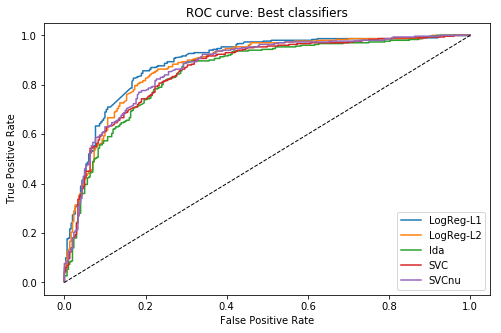

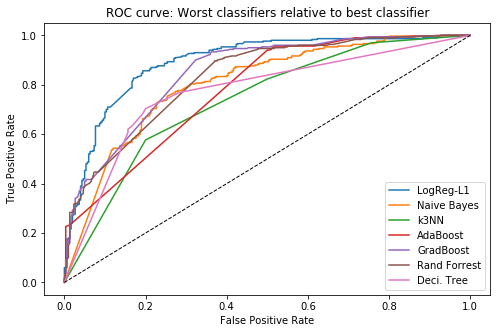

In [98]:
'''
Plot ROC for classifiers
'''
# 5 best
plt.figure(figsize = (8,5))
plt.plot(logregL1_info.fpr_curve,logregL1_info.tpr_curve)
plt.plot(logregL2_info.fpr_curve,logregL2_info.tpr_curve)
plt.plot(lda_info.fpr_curve,lda_info.tpr_curve)
plt.plot(svc1_info.fpr_curve,svc1_info.tpr_curve)
plt.plot(svcnu_info.fpr_curve,svcnu_info.tpr_curve)
plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1)
plt.legend(['LogReg-L1','LogReg-L2','lda','SVC','SVCnu'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Best classifiers')
plt.show()

# 5 worst
plt.figure(figsize = (8,5))
plt.plot(logregL1_info.fpr_curve, logregL1_info.tpr_curve)
plt.plot(nb_info.fpr_curve,nb_info.tpr_curve)
plt.plot(k3nn_info.fpr_curve,k3nn_info.tpr_curve)
plt.plot(abc_info.fpr_curve,abc_info.tpr_curve)
plt.plot(gbc_info.fpr_curve,gbc_info.tpr_curve)
plt.plot(rf_info.fpr_curve,rf_info.tpr_curve)
plt.plot(tr_info.fpr_curve,tr_info.tpr_curve)
plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1)
plt.legend(['LogReg-L1','Naive Bayes','k3NN','AdaBoost','GradBoost', 'Rand Forrest', 'Deci. Tree'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Worst classifiers relative to best classifier')
plt.show()




In [1]:
# This will only work on a computer with graphviz installed

import graphviz 
from sklearn.tree import export_graphviz
from sklearn import tree
tr = DecisionTreeClassifier()
tr.fit(X_train, y_train)
dot_data = export_graphviz(tr, out_file=None, 
                      feature_names=vocabList,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)
graph

ModuleNotFoundError: No module named 'graphviz'

In [108]:
''' 
Create a table of Accuracy, TPR, FPR, AUC for each model

The values from the table were exported into Excel and Matlab
to create plots + make formatting look nice
'''

import gc

# Create a list with model name and FPR value
fpr_all = list()

print('FPR \n')
indx = 0
for obj in gc.get_objects():
    if isinstance(obj, modDetails):
        fpr_all.append([obj.name,          # model name
                        round(obj.train_cvscores.mean()*100,4),   # Model Cross Val Accuracy on Training data
                        round(obj.train_cvscores.std()*100,2),    # Cross Val standard dev. on Training data
                        #round((1- sum(abs(obj.predictionsTrain - y_train)) / len(y_train))*100,4),            # Accuracy on Test Data
                        round((obj.cfm_test[0]+obj.cfm_test[3])/600*100,4), # Another measure of accuracy
                        round(obj.fpr,4)*100,   # FPR on Test Data
                        round(obj.tpr,4)*100,  # TPR on Test Data
                        round(obj.auc,4),      # AUC
                        round((obj.cfm_train[0]+obj.cfm_train[3])/2400*100,4),])  # Training accuracy
        
        #print(obj.name + ': ' + str(round(obj.tpr,4)*100))
        indx = indx + 1

for val in fpr_all:
    print(*val, sep='\t')


FPR 

LogReg-L2	77.875	2.45	80.8333	23.189999999999998	86.27	0.8788	86.7083
LogReg-L1	78.1667	2.85	81.8333	21.83	86.59	0.8922	85.75
lda	75.2083	3.41	78.0	24.7	81.34	0.8514	87.375
SVC rbf	59.4167	4.46	58.1667	45.49	92.97999999999999	0.8175	60.375
SVC linear, C1	77.75	3.01	78.3333	24.85	82.44	0.8617	87.5833
SVCnu	77.5	2.82	79.5	24.05	84.17	0.87	86.4583
k3NN	67.75	4.73	66.1667	37.78	73.89	0.7375	82.4583
AdaBoost	69.9583	4.86	71.5	35.44	91.08000000000001	0.7785	71.875
Gradient Boost	74.5	3.85	76.3333	30.64	91.14999999999999	0.847	78.8333
Random Forest	70.5	4.03	71.5	35.370000000000005	90.57	0.8291	72.7917
Decision Tree	69.1667	3.44	74.3333	26.6	75.35	0.7712	97.8333
SVC linear, C100	72.6667	3.91	75.5	26.32	77.62	0.832	91.3333
GaussianNB	70.3333	2.13	70.5	21.13	65.89	0.8049	77.9167
